In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import sys, os
import sklearn
import datetime

import importlib
from tqdm import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import cri_calc as cri
importlib.reload(cri)

import cri_helper as helper
importlib.reload(helper)

import nn_evaluation as nne
importlib.reload(nne)

<module 'nn_evaluation' from '/Users/andrewt/Documents/Univ. Piraeus Research Center/VCRA/nn_evaluation.py'>

In [3]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn_rvm import EMRVR

from sklearn.neural_network import MLPRegressor

EPS = 1e-2
pd.set_option('display.max_columns', None)

In [4]:
def evaluate_clf(clf, X, y, train_index, test_index, include_indices=False):
    print(f'Training with {len(train_index)} samples; Testing with {len(test_index)} samples')
    
    # Get Train/Test Sets
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train, y_test = y.iloc[train_index].values, y.iloc[test_index].values

    # Train Model on Selected Fold
    clf.fit(X_train, y_train)
    y_pred = np.clip(clf.predict(X_test), 0, 1)
    
    # Organize and Return Results
    result = dict(
        instance = clf,
        X_train=X_train,
        X_test=X_test,
        y_train = y_train,        
        y_true = y_test,
        y_pred = y_pred,
        acc = clf.score(X_test, y_test),
        mae = mean_absolute_error(y_test, y_pred),
        rmse = mean_squared_error(y_test, y_pred, squared=False),
        rmsle = mean_squared_log_error(y_test, y_pred, squared=False),
    )
        
    if include_indices:
        result.update({
            'train_indices':train_index,
            'test_indices':test_index
        })
        
    return result

# Loading and Preparing CRI Dataset

In [5]:
gdf_vcra = pd.read_pickle('./data/norway-dataset/oslo_jan_mar_2019_4w_prep_encountering.vcra_dataset_v14.pickle')
gdf_vcra.loc[:, 'ves_cri_bin'] = pd.cut(
    gdf_vcra.ves_cri, 
    bins=np.arange(0, 1.1, .2),  
    right=True, 
    include_lowest=True
)

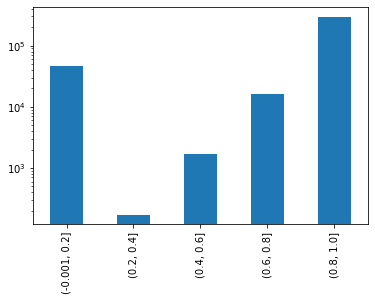

In [6]:
ax = gdf_vcra.ves_cri_bin.value_counts(sort=False).plot.bar()
ax.set_yscale('log')

## Get a Stratified Subset (to ensure a "fair" comparison)

In [7]:
X, y, y_bin = gdf_vcra.iloc[:, :-2], gdf_vcra.iloc[:, -2], gdf_vcra.iloc[:, -1].astype('str')
X_sub, _, y_sub, _, y_bin_sub, _ = train_test_split(X, y, y_bin, train_size=0.35, random_state=10, stratify=y_bin)

# SVM-VCRA (Gang et al.)

In [ ]:
# svm_vcra_features = ['dist_euclid', 'own_speed', 'target_speed', 'own_course', 'target_course', 'relative_bearing_target_to_own']
svm_vcra_features = ['dist_euclid', 'own_speed', 'target_speed', 'own_course_rad', 'target_course_rad', 'relative_bearing_target_to_own']

svm_vcra_training_data = X_sub.loc[:, svm_vcra_features].copy()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
clf = make_pipeline(StandardScaler(), SVR(gamma='auto', kernel='rbf', verbose=True))
    
svm_vcra_skf_results = Parallel(n_jobs=-1)(delayed(evaluate_clf)(
    clf, svm_vcra_training_data, y_sub, train_index, test_index
) for (train_index, test_index) in tqdm(skf.split(X_sub, y_bin_sub), total=skf.get_n_splits(X_sub, y_bin_sub)))

In [ ]:
svm_vcra_skf_results_df = pd.DataFrame(svm_vcra_skf_results)
svm_vcra_skf_results_df

In [ ]:
svm_vcra_skf_results_df.to_pickle('./data/pickle/svm_vcra_skf_results_v14.pickle')

# RVM-VCRA (Park et al.)

In [ ]:
# rvm_vcra_features = ['dist_euclid', 'own_speed', 'target_speed', 'own_course', 'target_course', 'relative_bearing_target_to_own', 'own_length', 'target_length']
rvm_vcra_features = ['dist_euclid', 'own_speed', 'target_speed', 'own_course_rad', 'target_course_rad', 'relative_bearing_target_to_own', 'own_length_nmi', 'target_length_nmi']

rvm_vcra_training_data = X_sub.loc[:, rvm_vcra_features].copy()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
clf = make_pipeline(StandardScaler(), EMRVR(kernel='rbf', verbose=True))
    
rvm_vcra_skf_results = Parallel(n_jobs=1)(delayed(evaluate_clf)(
    clf, rvm_vcra_training_data, y_sub, train_index, test_index
) for (train_index, test_index) in tqdm(skf.split(X_sub, y_bin_sub), total=skf.get_n_splits(X_sub, y_bin_sub)))

In [ ]:
rvm_vcra_skf_results_df = pd.DataFrame(rvm_vcra_skf_results)
rvm_vcra_skf_results_df

In [ ]:
rvm_vcra_skf_results_df.to_pickle('./data/pickle/rvm_vcra_skf_results_v14.pickle')

# CART-VCRA (Li et al.)

In [ ]:
# cart_vcra_features = ['dist_euclid', 'own_speed', 'target_speed', 'own_course', 'target_course', 'azimuth_angle_target_to_own']
cart_vcra_features = ['dist_euclid', 'own_speed', 'target_speed', 'own_course_rad', 'target_course_rad', 'azimuth_angle_target_to_own']

cart_vcra_training_data = X_sub.loc[:, cart_vcra_features].copy()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
clf = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=10, verbose=True))
    
cart_vcra_skf_results = Parallel(n_jobs=-1)(delayed(evaluate_clf)(
    clf, cart_vcra_training_data, y_sub, train_index, test_index
) for (train_index, test_index) in tqdm(skf.split(X_sub, y_bin_sub), total=skf.get_n_splits(X_sub, y_bin_sub)))

In [ ]:
cart_vcra_skf_results_df = pd.DataFrame(cart_vcra_skf_results)
cart_vcra_skf_results_df

In [ ]:
cart_vcra_skf_results_df.to_pickle('./data/pickle/cart_vcra_skf_results_v14.pickle')

# MLP-VCRA (Ours)

In [ ]:
# # mlp_vcra_features = ['own_speed', 'own_course', 'target_speed', 'target_course', 'dist_euclid', 'relative_bearing_target_to_own', 'rel_movement_direction']
# mlp_vcra_features = ['own_speed', 'own_course', 'target_speed', 'target_course', 'dist_euclid', 'azimuth_angle_target_to_own', 'rel_movement_direction']
mlp_vcra_features = ['own_speed', 'own_course_rad', 'target_speed', 'target_course_rad', 'dist_euclid', 'azimuth_angle_target_to_own', 'rel_movement_direction']

mlp_vcra_training_data = X_sub.loc[:, mlp_vcra_features].copy()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
regr = make_pipeline(
    StandardScaler(), 
    MLPRegressor(random_state=10, max_iter=300, hidden_layer_sizes=(256, 32), 
                 verbose=True, early_stopping=True, n_iter_no_change=7)
)

mlp_vcra_skf_results = Parallel(n_jobs=-1)(delayed(evaluate_clf)(
    regr, mlp_vcra_training_data, y_sub, train_index, test_index
) for (train_index, test_index) in tqdm(skf.split(X_sub, y_bin_sub), total=skf.get_n_splits(X_sub, y_bin_sub)))

In [ ]:
mlp_vcra_skf_results_df = pd.DataFrame(mlp_vcra_skf_results)
mlp_vcra_skf_results_df

In [ ]:
mlp_vcra_skf_results_df.to_pickle('./data/pickle/mlp_vcra_skf_results_v14.pickle')

# Combining Results to a Unified DataFrame

In [8]:
cart_vcra_skf_results_df = pd.read_pickle('./data/pickle/cart_vcra_skf_results_v14.pickle')
svm_vcra_skf_results_df = pd.read_pickle('./data/pickle/svm_vcra_skf_results_v14.pickle')
rvm_vcra_skf_results_df = pd.read_pickle('./data/pickle/rvm_vcra_skf_results_v14.pickle')
mlp_vcra_skf_results_df = pd.read_pickle('./data/pickle/mlp_vcra_skf_results_v14.pickle')

skf_results_df = pd.concat({
    'cart_vcra': cart_vcra_skf_results_df, 
    'svm_vcra': svm_vcra_skf_results_df,
    'rvm_vcra': rvm_vcra_skf_results_df,
    'mlp_vcra': mlp_vcra_skf_results_df
}, names=['model'])

In [9]:
skf_results_df.loc[:, 'r2_score'] = skf_results_df.apply(lambda l: sklearn.metrics.r2_score(l.y_true, l.y_pred), axis=1)

In [11]:
skf_results_df.groupby(level=0, sort=False).mean(numeric_only=True)

,acc,mae,rmse,rmsle,r2_score
model,,,,,
cart_vcra,0.851717,0.039487,0.116528,0.085264,0.851717
svm_vcra,0.568810,0.119438,0.196918,0.145188,0.576567
rvm_vcra,0.572970,0.127159,0.193644,0.137909,0.590550
mlp_vcra,0.959264,0.024619,0.060669,0.043949,0.959734


In [12]:
skf_results_df.to_pickle('./data/pickle/vcra_skf_results_df_v14.pickle')

# Li et. al vs. VCRA/F @ Full Dataset
## Load Data

In [7]:
## Split to Train/Test set (to ensure a "fair" comparison)
X, y, y_bin = gdf_vcra.iloc[:, :-2], gdf_vcra.iloc[:, -2], gdf_vcra.iloc[:, -1].astype('str')

## Li et al.

In [8]:
# cart_vcra_features = ['dist_euclid', 'own_speed', 'target_speed', 'own_course', 'target_course', 'azimuth_angle_target_to_own']
cart_vcra_features = ['dist_euclid', 'own_speed', 'target_speed', 'own_course_rad', 'target_course_rad', 'azimuth_angle_target_to_own']

cart_vcra_training_data = X.loc[:, cart_vcra_features].copy()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
cart_vcra_lietal = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=10, verbose=True))
    
cart_vcra_skf_results = Parallel(n_jobs=-1)(delayed((evaluate_clf))(
    cart_vcra_lietal, cart_vcra_training_data, y, train_index, test_index, include_indices=True
) for (train_index, test_index) in tqdm(skf.split(X, y_bin), total=skf.get_n_splits(X, y_bin)))

cart_vcra_skf_results_df = pd.DataFrame(cart_vcra_skf_results)
cart_vcra_skf_results_df

In [10]:
cart_vcra_skf_results_df.to_pickle('./data/pickle/cart_vcra_skf_results_v14.trained_on_all_data.pickle')

## VCRA/F

In [11]:
## mlp_vcra_features = ['own_speed', 'own_course', 'target_speed', 'target_course', 'dist_euclid', 'relative_bearing_target_to_own', 'rel_movement_direction']
# mlp_vcra_features = ['own_speed', 'own_course', 'target_speed', 'target_course', 'dist_euclid', 'azimuth_angle_target_to_own', 'rel_movement_direction']
mlp_vcra_features = ['own_speed', 'own_course_rad', 'target_speed', 'target_course_rad', 'dist_euclid', 'azimuth_angle_target_to_own', 'rel_movement_direction']

mlp_vcra_training_data = X.loc[:, mlp_vcra_features].copy()

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
mlp_vcra_ours = make_pipeline(
    StandardScaler(), 
    MLPRegressor(random_state=10, max_iter=100, hidden_layer_sizes=(256, 32), 
                 verbose=True, early_stopping=True, n_iter_no_change=10)
)

mlp_vcra_skf_results = Parallel(n_jobs=-1)(delayed(evaluate_clf)(
    mlp_vcra_ours, mlp_vcra_training_data, y, train_index, test_index, include_indices=True
) for (train_index, test_index) in tqdm(skf.split(X, y_bin), total=skf.get_n_splits(X, y_bin)))

mlp_vcra_skf_results_df = pd.DataFrame(mlp_vcra_skf_results)
mlp_vcra_skf_results_df

In [ ]:
mlp_vcra_skf_results_df.to_pickle('./data/pickle/mlp_vcra_skf_results_v14.trained_on_all_data.pickle')

## Combining Results to a Unified DataFrame

In [14]:
cart_vcra_skf_results_df = pd.read_pickle('./data/pickle/cart_vcra_skf_results_v14.trained_on_all_data.pickle')
mlp_vcra_skf_results_df = pd.read_pickle('./data/pickle/mlp_vcra_skf_results_v14.trained_on_all_data.pickle')

skf_results_df = pd.concat({
    'cart_vcra': cart_vcra_skf_results_df, 
    'mlp_vcra': mlp_vcra_skf_results_df
}, names=['model'])

In [15]:
skf_results_df.loc[:, 'r2_score'] = skf_results_df.apply(lambda l: sklearn.metrics.r2_score(l.y_true, l.y_pred), axis=1)

In [17]:
skf_results_df.to_pickle('./data/pickle/vcra_skf_results_df.cart_vs_mlp.trained_on_all_data.pickle')

In [16]:
skf_results_df.groupby(level=0).mean(numeric_only=True)

,acc,mae,rmse,rmsle,r2_score
model,,,,,
cart_vcra,0.886719,0.031447,0.101848,0.074772,0.886719
mlp_vcra,0.969927,0.019279,0.052141,0.037807,0.970156


In [71]:
def metrics_per_cri_pct(sdf):
    buckets = pd.cut(sdf.y_true, bins, right=True, include_lowest=True)
    return pd.DataFrame({'y_true': sdf.y_true, 'y_pred': sdf.y_pred}).groupby(buckets).apply(
        lambda l: mean_squared_log_error(l.y_true, l.y_pred, squared=False)
    )
    

skf_results_df.apply(
    lambda l: metrics_per_cri_pct(l), 
    axis=1
).groupby(level=0).mean()

,"(-0.001, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
model,,,,,
cart_vcra,0.179458,0.066316,0.067501,0.058542,0.038912
mlp_vcra,0.086902,0.075979,0.049615,0.031168,0.021532


In [79]:
Out[71].columns = ['[0, 0.2]', '(0.2, 0.4]', '(0.4, 0.6]', '(0.6, 0.8]', '(0.8, 1.0]']

In [80]:
Out[71]

,"[0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
model,,,,,
cart_vcra,0.179458,0.066316,0.067501,0.058542,0.038912
mlp_vcra,0.086902,0.075979,0.049615,0.031168,0.021532
